# Vasicek Interest Rate Model

## Introduction

The **Vasicek model**, introduced by Oldřich Vašíček in 1977, is one of the earliest and most influential mathematical models for describing the evolution of interest rates. It belongs to the class of **short-rate models**, which model the instantaneous interest rate (or short rate) as a stochastic process.

## Mathematical Framework

### The Stochastic Differential Equation

The Vasicek model describes the short rate $r_t$ through the following stochastic differential equation (SDE):

$$dr_t = \kappa(\theta - r_t)dt + \sigma dW_t$$

where:
- $r_t$ is the instantaneous short rate at time $t$
- $\kappa > 0$ is the **speed of mean reversion**
- $\theta$ is the **long-term mean level** of the interest rate
- $\sigma > 0$ is the **volatility** of the interest rate
- $W_t$ is a standard Wiener process (Brownian motion)

### Mean-Reversion Property

The term $\kappa(\theta - r_t)$ represents the **drift** component and exhibits mean-reverting behavior:
- When $r_t > \theta$, the drift is negative, pushing rates down toward $\theta$
- When $r_t < \theta$, the drift is positive, pushing rates up toward $\theta$

### Analytical Solution

The Vasicek model has a closed-form solution. Given an initial rate $r_0$, the short rate at time $t$ is:

$$r_t = r_0 e^{-\kappa t} + \theta(1 - e^{-\kappa t}) + \sigma \int_0^t e^{-\kappa(t-s)} dW_s$$

This can be rewritten as:

$$r_t = r_0 e^{-\kappa t} + \theta(1 - e^{-\kappa t}) + \sigma \sqrt{\frac{1 - e^{-2\kappa t}}{2\kappa}} Z$$

where $Z \sim \mathcal{N}(0, 1)$ is a standard normal random variable.

### Distribution of $r_t$

The short rate $r_t$ follows a **normal distribution** with:

**Expected value:**
$$\mathbb{E}[r_t | r_0] = r_0 e^{-\kappa t} + \theta(1 - e^{-\kappa t})$$

**Variance:**
$$\text{Var}(r_t | r_0) = \frac{\sigma^2}{2\kappa}(1 - e^{-2\kappa t})$$

### Long-Term Distribution

As $t \to \infty$, the distribution converges to a stationary distribution:

$$r_\infty \sim \mathcal{N}\left(\theta, \frac{\sigma^2}{2\kappa}\right)$$

## Bond Pricing

One of the key applications of the Vasicek model is pricing zero-coupon bonds. The price at time $t$ of a zero-coupon bond maturing at time $T$ is:

$$P(t, T) = A(t, T) e^{-B(t, T) r_t}$$

where:

$$B(t, T) = \frac{1 - e^{-\kappa(T-t)}}{\kappa}$$

$$A(t, T) = \exp\left[\left(\theta - \frac{\sigma^2}{2\kappa^2}\right)(B(t,T) - (T-t)) - \frac{\sigma^2}{4\kappa}B(t,T)^2\right]$$

## Advantages and Limitations

### Advantages
- Analytical tractability (closed-form solutions for bond prices)
- Mean-reverting behavior matches empirical observations
- Simple calibration with few parameters

### Limitations
- **Negative rates possible**: The normal distribution allows negative interest rates
- **Constant volatility**: Does not capture volatility clustering or term structure of volatility
- **Affine structure**: Limited flexibility in fitting market data

## Implementation

We will now implement the Vasicek model and simulate interest rate paths using both the exact solution and the Euler-Maruyama discretization scheme.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Model parameters
kappa = 0.5      # Speed of mean reversion
theta = 0.05     # Long-term mean (5%)
sigma = 0.02     # Volatility
r0 = 0.03        # Initial short rate (3%)

# Simulation parameters
T = 10           # Time horizon (years)
n_steps = 1000   # Number of time steps
n_paths = 100    # Number of simulation paths
dt = T / n_steps # Time step size

print("Vasicek Model Parameters:")
print(f"  κ (mean reversion speed): {kappa}")
print(f"  θ (long-term mean): {theta:.2%}")
print(f"  σ (volatility): {sigma}")
print(f"  r₀ (initial rate): {r0:.2%}")
print(f"\nSimulation Settings:")
print(f"  Time horizon: {T} years")
print(f"  Number of paths: {n_paths}")
print(f"  Time steps: {n_steps}")

Vasicek Model Parameters:
  κ (mean reversion speed): 0.5
  θ (long-term mean): 5.00%
  σ (volatility): 0.02
  r₀ (initial rate): 3.00%

Simulation Settings:
  Time horizon: 10 years
  Number of paths: 100
  Time steps: 1000


### Exact Simulation Method

Using the analytical solution, we can simulate exactly without discretization error:

In [2]:
def vasicek_exact(r0, kappa, theta, sigma, T, n_steps, n_paths):
    """
    Simulate Vasicek model paths using the exact analytical solution.
    
    Parameters:
    -----------
    r0 : float
        Initial short rate
    kappa : float
        Speed of mean reversion
    theta : float
        Long-term mean level
    sigma : float
        Volatility
    T : float
        Time horizon
    n_steps : int
        Number of time steps
    n_paths : int
        Number of simulation paths
        
    Returns:
    --------
    t : ndarray
        Time grid
    r : ndarray
        Simulated rate paths (n_steps+1 x n_paths)
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps + 1)
    
    # Initialize rate matrix
    r = np.zeros((n_steps + 1, n_paths))
    r[0, :] = r0
    
    # Precompute constants
    exp_kappa_dt = np.exp(-kappa * dt)
    variance = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt))
    std_dev = np.sqrt(variance)
    
    # Generate all random numbers at once
    Z = np.random.standard_normal((n_steps, n_paths))
    
    # Simulate paths
    for i in range(n_steps):
        r[i + 1, :] = (r[i, :] * exp_kappa_dt + 
                      theta * (1 - exp_kappa_dt) + 
                      std_dev * Z[i, :])
    
    return t, r

# Run exact simulation
t_exact, r_exact = vasicek_exact(r0, kappa, theta, sigma, T, n_steps, n_paths)

print(f"Simulation complete.")
print(f"Final rate statistics (exact method):")
print(f"  Mean: {r_exact[-1, :].mean():.4%}")
print(f"  Std Dev: {r_exact[-1, :].std():.4%}")
print(f"  Min: {r_exact[-1, :].min():.4%}")
print(f"  Max: {r_exact[-1, :].max():.4%}")

Simulation complete.
Final rate statistics (exact method):
  Mean: 4.9546%
  Std Dev: 1.8563%
  Min: -0.5918%
  Max: 9.2859%


### Euler-Maruyama Discretization

For comparison, we also implement the Euler-Maruyama scheme:

$$r_{t+\Delta t} = r_t + \kappa(\theta - r_t)\Delta t + \sigma \sqrt{\Delta t} Z$$

In [3]:
def vasicek_euler(r0, kappa, theta, sigma, T, n_steps, n_paths):
    """
    Simulate Vasicek model paths using Euler-Maruyama discretization.
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps + 1)
    
    r = np.zeros((n_steps + 1, n_paths))
    r[0, :] = r0
    
    sqrt_dt = np.sqrt(dt)
    Z = np.random.standard_normal((n_steps, n_paths))
    
    for i in range(n_steps):
        r[i + 1, :] = (r[i, :] + 
                      kappa * (theta - r[i, :]) * dt + 
                      sigma * sqrt_dt * Z[i, :])
    
    return t, r

# Run Euler simulation with same random seed for comparison
np.random.seed(42)
t_euler, r_euler = vasicek_euler(r0, kappa, theta, sigma, T, n_steps, n_paths)

print(f"Final rate statistics (Euler method):")
print(f"  Mean: {r_euler[-1, :].mean():.4%}")
print(f"  Std Dev: {r_euler[-1, :].std():.4%}")

Final rate statistics (Euler method):
  Mean: 4.9545%
  Std Dev: 1.8588%


### Theoretical Distribution

Let's compute the theoretical mean and variance at the final time:

In [4]:
def vasicek_moments(r0, kappa, theta, sigma, t):
    """
    Compute theoretical mean and variance of r_t.
    """
    exp_kt = np.exp(-kappa * t)
    mean = r0 * exp_kt + theta * (1 - exp_kt)
    var = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * t))
    return mean, var

# Theoretical values at T
theo_mean, theo_var = vasicek_moments(r0, kappa, theta, sigma, T)
theo_std = np.sqrt(theo_var)

# Long-term (stationary) distribution
stationary_mean = theta
stationary_std = sigma / np.sqrt(2 * kappa)

print("Theoretical Distribution at T = {} years:".format(T))
print(f"  Mean: {theo_mean:.4%}")
print(f"  Std Dev: {theo_std:.4%}")
print(f"\nStationary Distribution (t → ∞):")
print(f"  Mean: {stationary_mean:.4%}")
print(f"  Std Dev: {stationary_std:.4%}")

Theoretical Distribution at T = 10 years:
  Mean: 4.9865%
  Std Dev: 2.0000%

Stationary Distribution (t → ∞):
  Mean: 5.0000%
  Std Dev: 2.0000%


## Visualization

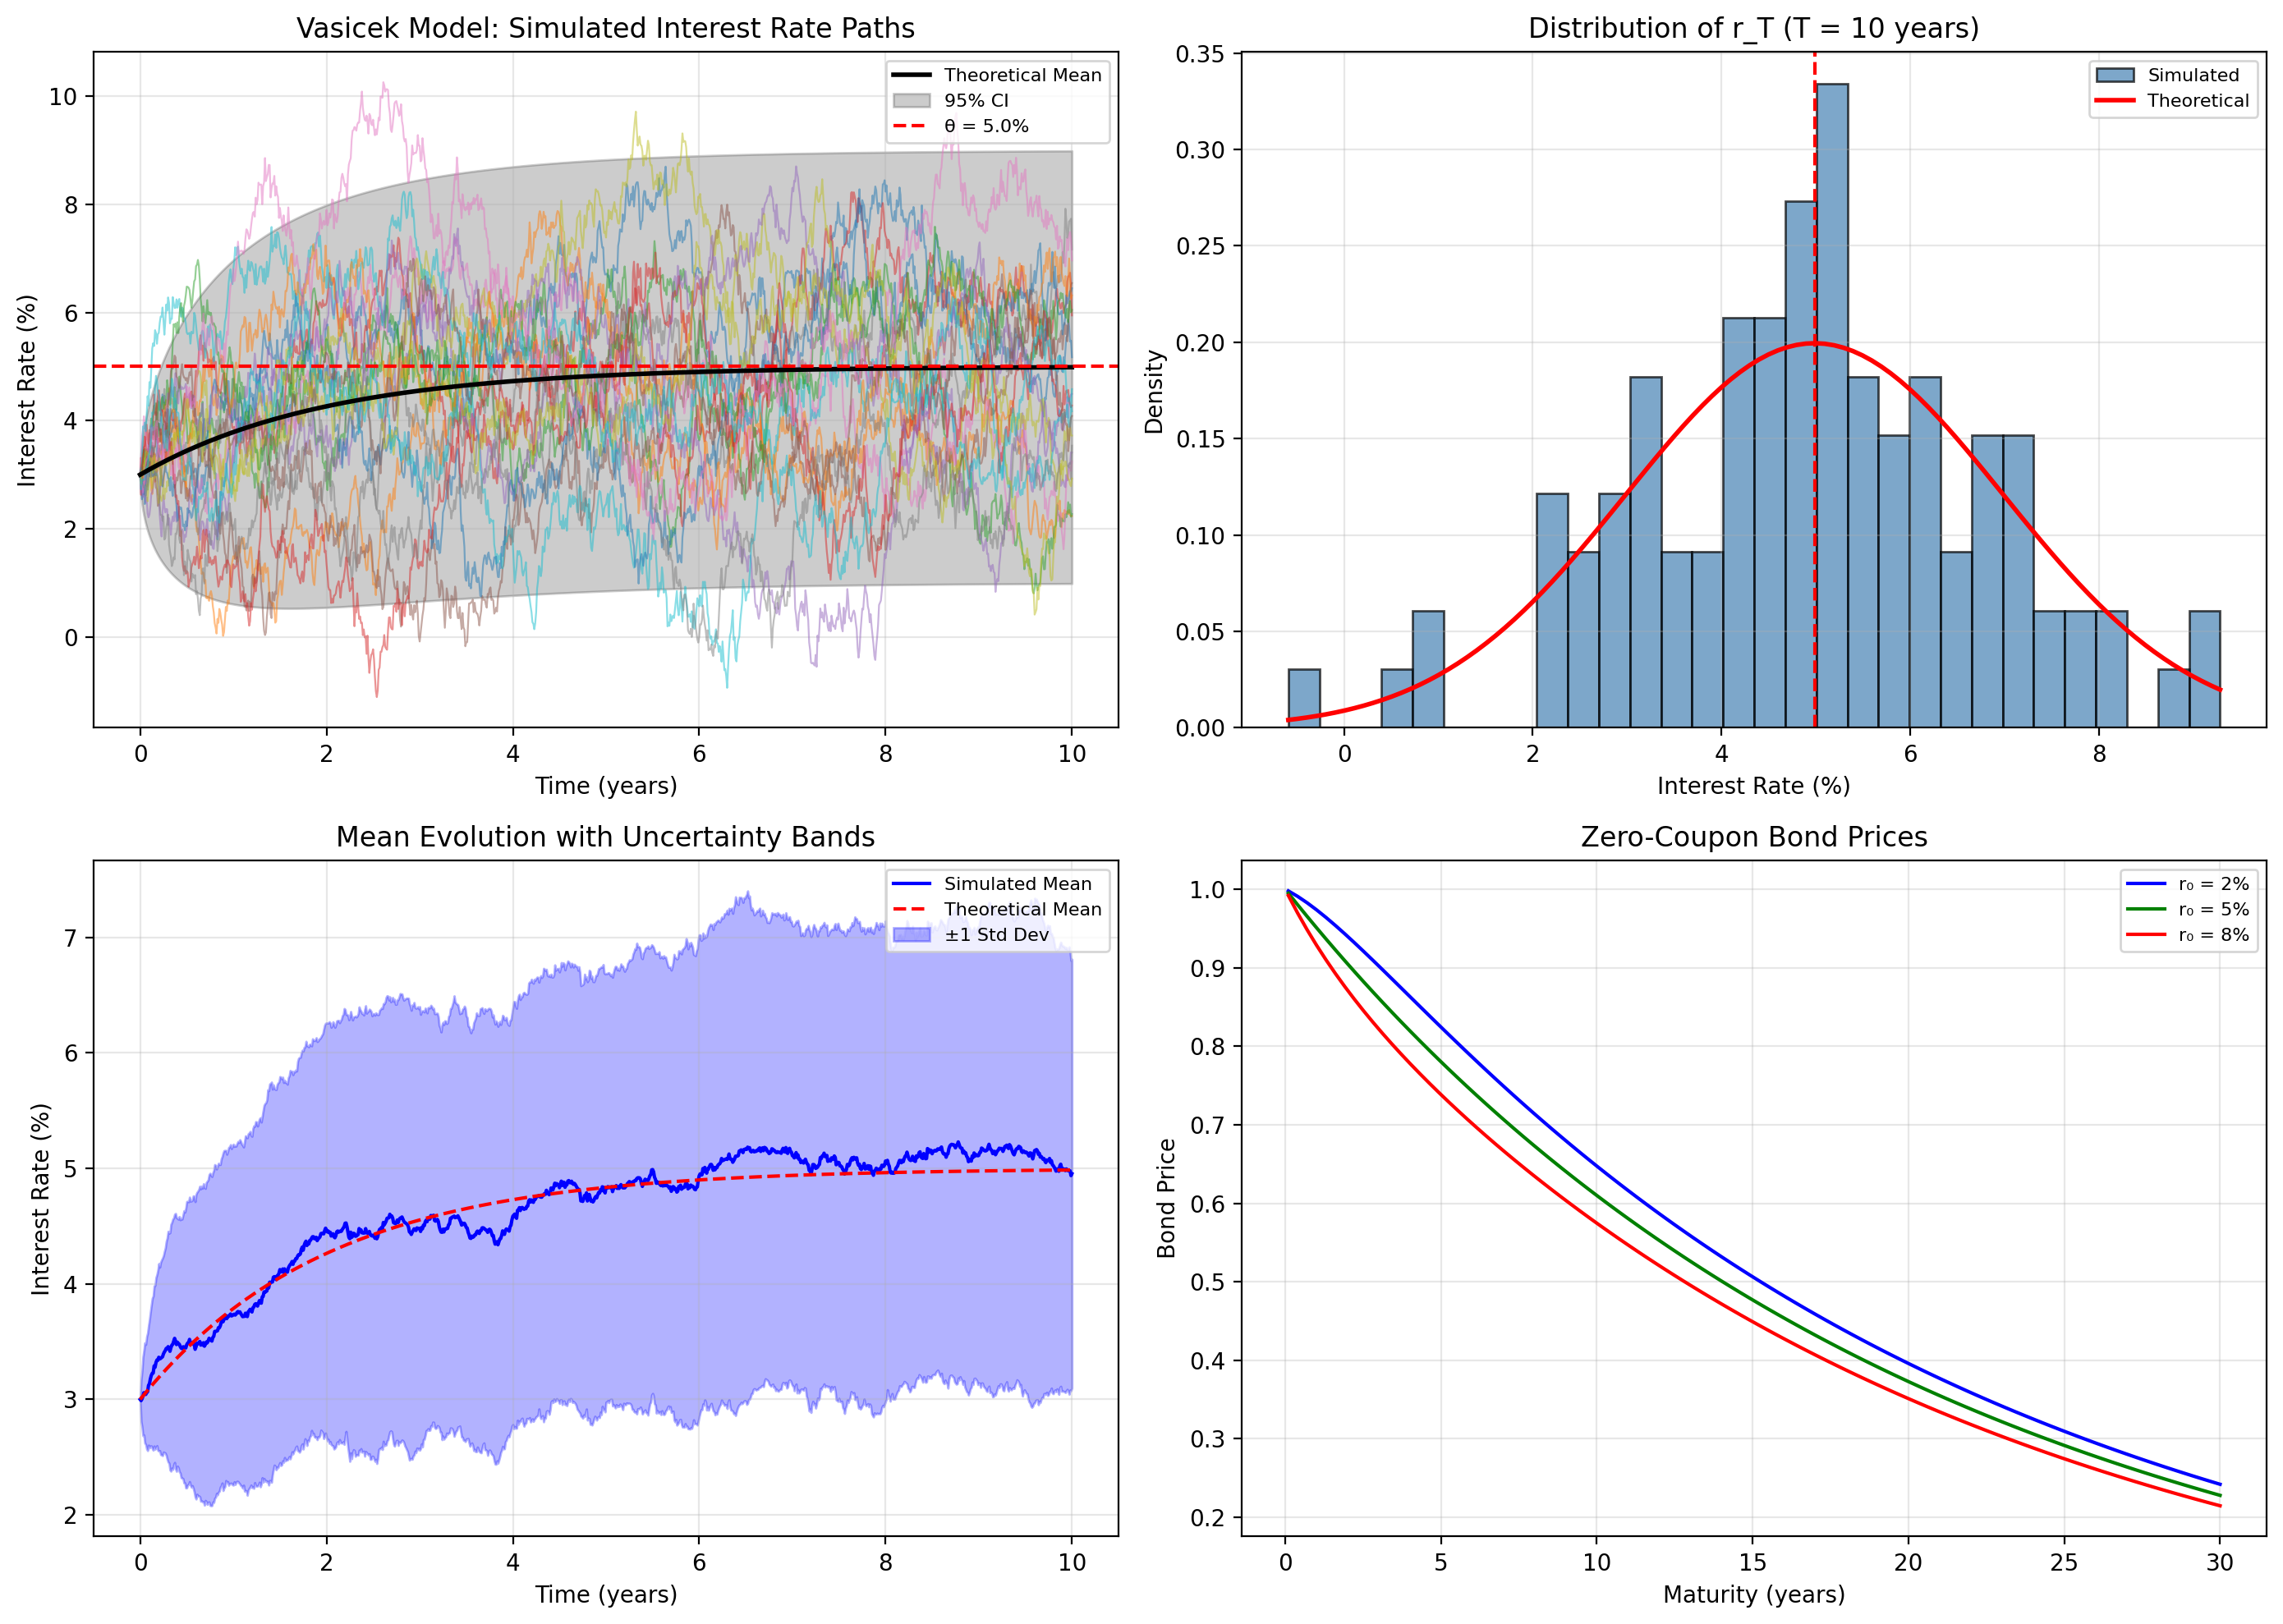


Plot saved to 'plot.png'


In [5]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Sample paths
ax1 = fig.add_subplot(2, 2, 1)
for i in range(min(20, n_paths)):
    ax1.plot(t_exact, r_exact[:, i] * 100, alpha=0.5, linewidth=0.8)

# Theoretical mean and confidence bands
theo_mean_path = np.array([vasicek_moments(r0, kappa, theta, sigma, ti)[0] for ti in t_exact])
theo_std_path = np.array([np.sqrt(vasicek_moments(r0, kappa, theta, sigma, ti)[1]) for ti in t_exact])

ax1.plot(t_exact, theo_mean_path * 100, 'k-', linewidth=2, label='Theoretical Mean')
ax1.fill_between(t_exact, 
                  (theo_mean_path - 2*theo_std_path) * 100,
                  (theo_mean_path + 2*theo_std_path) * 100,
                  alpha=0.2, color='black', label='95% CI')
ax1.axhline(y=theta * 100, color='r', linestyle='--', linewidth=1.5, label=f'θ = {theta:.1%}')

ax1.set_xlabel('Time (years)', fontsize=10)
ax1.set_ylabel('Interest Rate (%)', fontsize=10)
ax1.set_title('Vasicek Model: Simulated Interest Rate Paths', fontsize=12)
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution at final time
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(r_exact[-1, :] * 100, bins=30, density=True, alpha=0.7, 
         color='steelblue', edgecolor='black', label='Simulated')

# Theoretical PDF
x_range = np.linspace(r_exact[-1, :].min(), r_exact[-1, :].max(), 100)
theo_pdf = norm.pdf(x_range, theo_mean, theo_std)
ax2.plot(x_range * 100, theo_pdf / 100, 'r-', linewidth=2, label='Theoretical')

ax2.axvline(x=theo_mean * 100, color='r', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Interest Rate (%)', fontsize=10)
ax2.set_ylabel('Density', fontsize=10)
ax2.set_title(f'Distribution of r_T (T = {T} years)', fontsize=12)
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Mean and variance evolution
ax3 = fig.add_subplot(2, 2, 3)

# Simulated statistics
sim_mean = r_exact.mean(axis=1) * 100
sim_std = r_exact.std(axis=1) * 100

ax3.plot(t_exact, sim_mean, 'b-', linewidth=1.5, label='Simulated Mean')
ax3.plot(t_exact, theo_mean_path * 100, 'r--', linewidth=1.5, label='Theoretical Mean')
ax3.fill_between(t_exact, sim_mean - sim_std, sim_mean + sim_std, 
                  alpha=0.3, color='blue', label='±1 Std Dev')

ax3.set_xlabel('Time (years)', fontsize=10)
ax3.set_ylabel('Interest Rate (%)', fontsize=10)
ax3.set_title('Mean Evolution with Uncertainty Bands', fontsize=12)
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Zero-coupon bond prices
ax4 = fig.add_subplot(2, 2, 4)

def bond_price(r, t, T, kappa, theta, sigma):
    """Calculate zero-coupon bond price using Vasicek formula."""
    tau = T - t
    B = (1 - np.exp(-kappa * tau)) / kappa
    A = np.exp((theta - sigma**2 / (2 * kappa**2)) * (B - tau) - 
               (sigma**2 / (4 * kappa)) * B**2)
    return A * np.exp(-B * r)

# Bond prices for different maturities
maturities = np.linspace(0.1, 30, 100)
rates_to_plot = [0.02, 0.05, 0.08]
colors = ['blue', 'green', 'red']

for r_val, color in zip(rates_to_plot, colors):
    prices = [bond_price(r_val, 0, mat, kappa, theta, sigma) for mat in maturities]
    ax4.plot(maturities, prices, color=color, linewidth=1.5, 
             label=f'r₀ = {r_val:.0%}')

ax4.set_xlabel('Maturity (years)', fontsize=10)
ax4.set_ylabel('Bond Price', fontsize=10)
ax4.set_title('Zero-Coupon Bond Prices', fontsize=12)
ax4.legend(loc='upper right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vasicek_interest_rate_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Yield Curve Analysis

The yield curve implied by the Vasicek model provides insight into the term structure of interest rates.

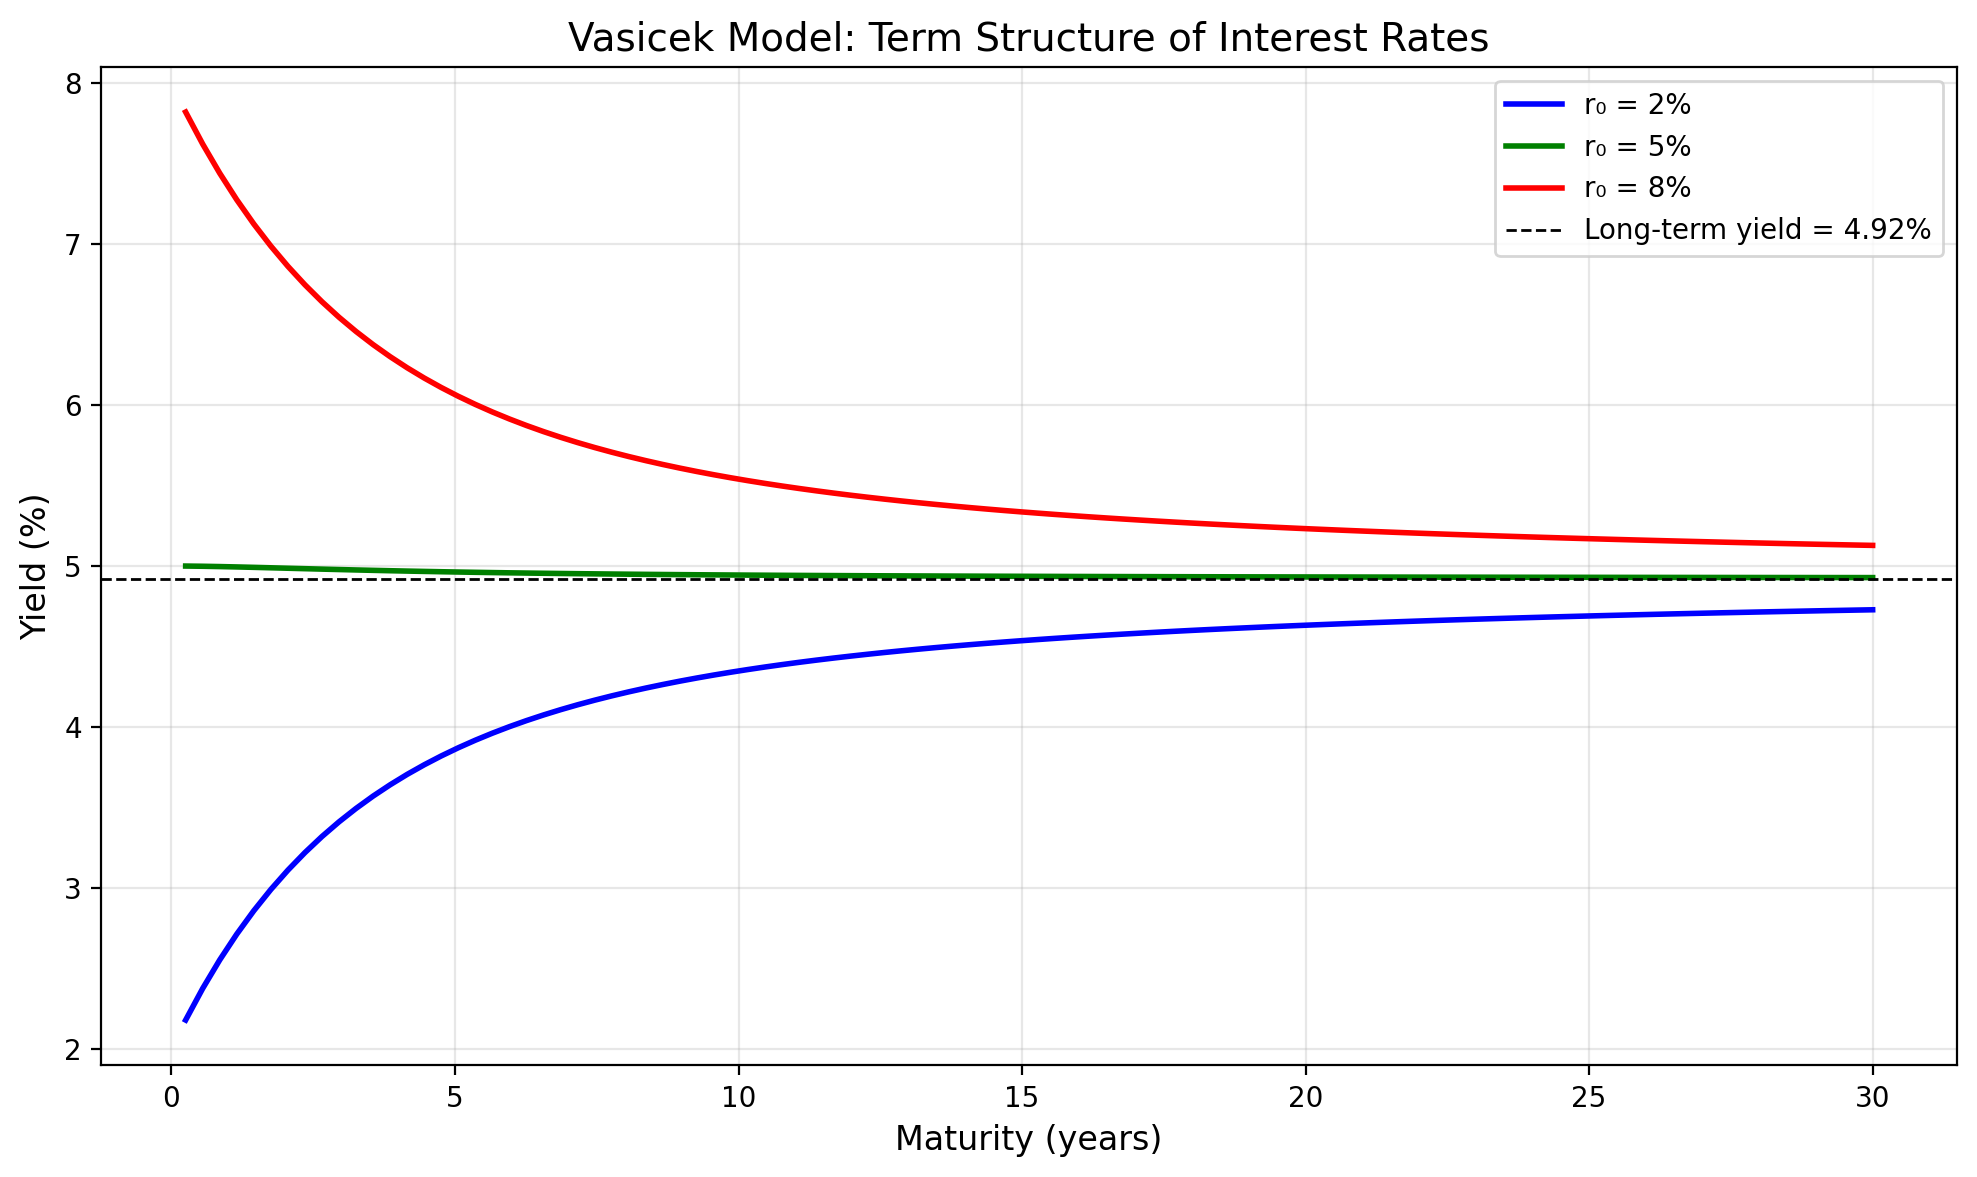


Long-term yield (as T → ∞): 4.9200%
This differs from θ = 5.0000% due to convexity adjustment


In [6]:
def yield_curve(r, t, T, kappa, theta, sigma):
    """Calculate continuously compounded yield."""
    tau = T - t
    if tau <= 0:
        return r
    P = bond_price(r, t, T, kappa, theta, sigma)
    return -np.log(P) / tau

# Generate yield curves for different short rates
maturities = np.linspace(0.25, 30, 100)

plt.figure(figsize=(10, 6))

for r_val, color in zip(rates_to_plot, colors):
    yields = [yield_curve(r_val, 0, mat, kappa, theta, sigma) * 100 
              for mat in maturities]
    plt.plot(maturities, yields, color=color, linewidth=2, 
             label=f'r₀ = {r_val:.0%}')

# Long-term yield
r_inf = theta - sigma**2 / (2 * kappa**2)
plt.axhline(y=r_inf * 100, color='black', linestyle='--', 
            linewidth=1, label=f'Long-term yield = {r_inf:.2%}')

plt.xlabel('Maturity (years)', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.title('Vasicek Model: Term Structure of Interest Rates', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLong-term yield (as T → ∞): {r_inf:.4%}")
print(f"This differs from θ = {theta:.4%} due to convexity adjustment")

## Parameter Sensitivity Analysis

Let's examine how the model behavior changes with different parameter values.

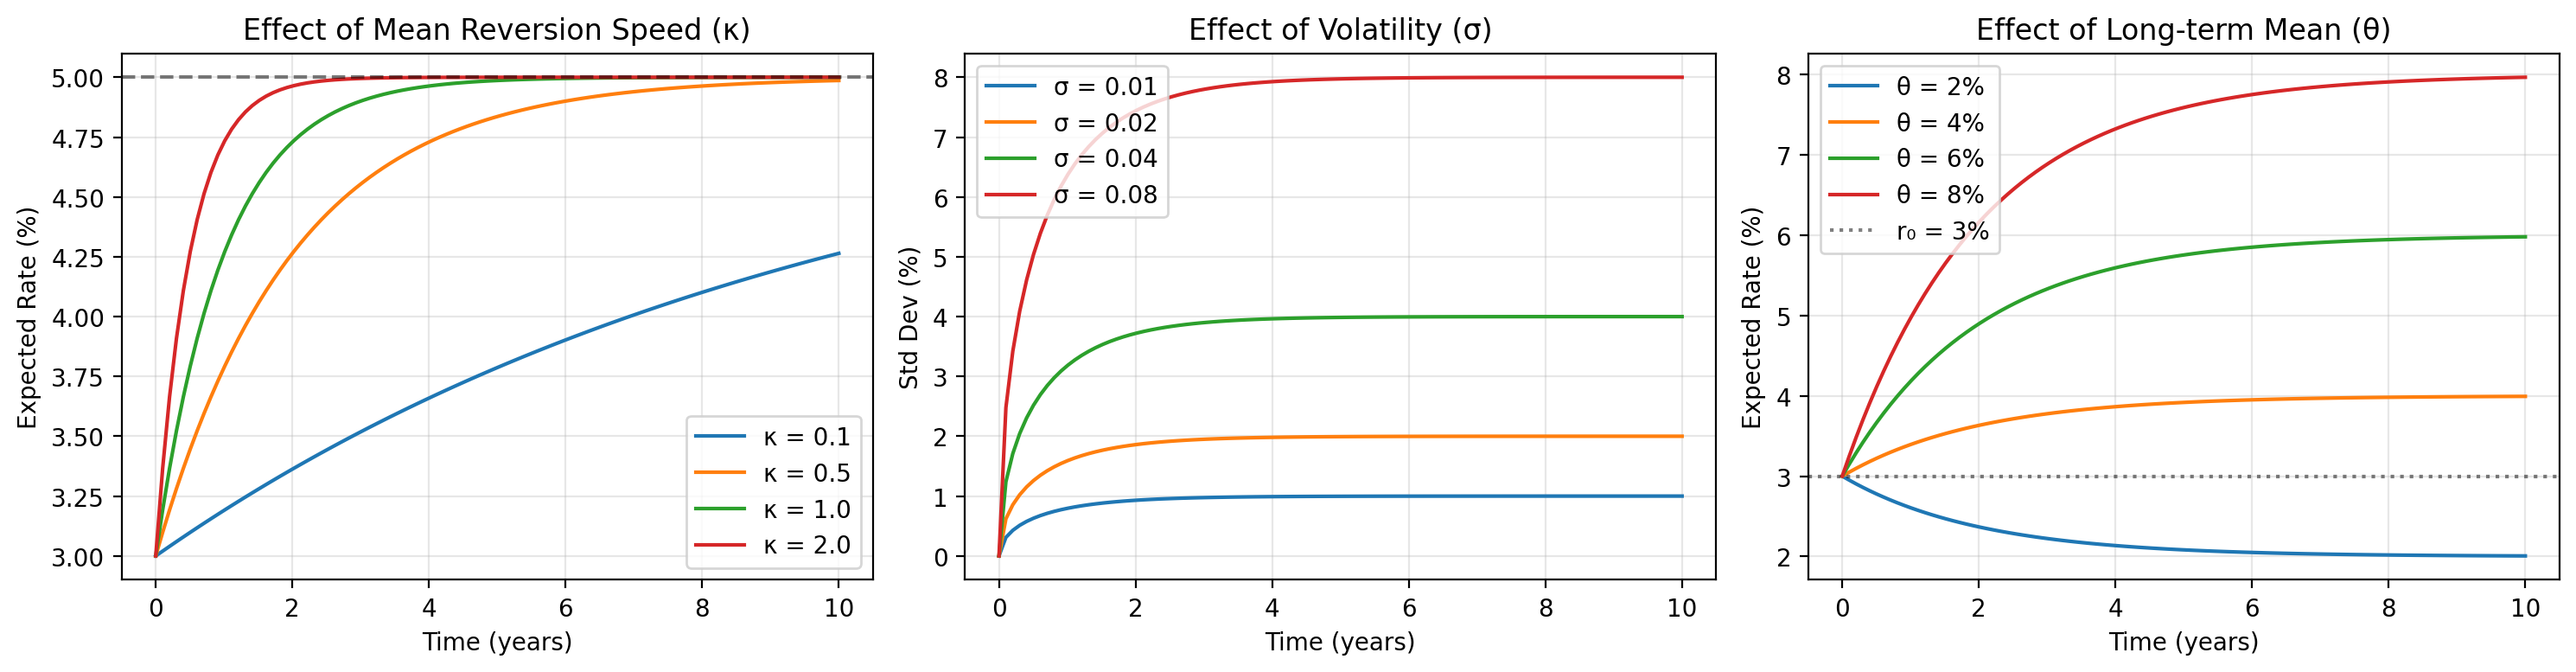

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

t_grid = np.linspace(0, 10, 100)

# Effect of kappa (mean reversion speed)
ax = axes[0]
for k in [0.1, 0.5, 1.0, 2.0]:
    means = [r0 * np.exp(-k*t) + theta * (1 - np.exp(-k*t)) for t in t_grid]
    ax.plot(t_grid, np.array(means) * 100, label=f'κ = {k}')
ax.axhline(y=theta * 100, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Expected Rate (%)')
ax.set_title('Effect of Mean Reversion Speed (κ)')
ax.legend()
ax.grid(True, alpha=0.3)

# Effect of sigma (volatility)
ax = axes[1]
for s in [0.01, 0.02, 0.04, 0.08]:
    vars_t = [(s**2 / (2*kappa)) * (1 - np.exp(-2*kappa*t)) for t in t_grid]
    stds = np.sqrt(vars_t) * 100
    ax.plot(t_grid, stds, label=f'σ = {s}')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Std Dev (%)')
ax.set_title('Effect of Volatility (σ)')
ax.legend()
ax.grid(True, alpha=0.3)

# Effect of theta (long-term mean)
ax = axes[2]
for th in [0.02, 0.04, 0.06, 0.08]:
    means = [r0 * np.exp(-kappa*t) + th * (1 - np.exp(-kappa*t)) for t in t_grid]
    ax.plot(t_grid, np.array(means) * 100, label=f'θ = {th:.0%}')
ax.axhline(y=r0 * 100, color='k', linestyle=':', alpha=0.5, label=f'r₀ = {r0:.0%}')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Expected Rate (%)')
ax.set_title('Effect of Long-term Mean (θ)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

The Vasicek model provides a foundational framework for interest rate modeling with several key properties:

1. **Mean reversion**: Interest rates naturally gravitate toward a long-term equilibrium level
2. **Analytical tractability**: Closed-form solutions exist for bond prices and option values
3. **Normal distribution**: The short rate follows a Gaussian distribution at any future time

While the model's simplicity makes it valuable for educational purposes and initial analysis, practitioners should be aware of its limitations, particularly the possibility of negative interest rates. Modern extensions like the Cox-Ingersoll-Ross (CIR) model address some of these shortcomings while maintaining analytical tractability.